In [2]:
import zipfile
import os

zip_path = "/content/disml_dataset.zip"
extract_path = "/content/"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping complete!")

Unzipping complete!


In [3]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv("/content/DISML_project_dataset/idlabel.csv")

In [6]:
non_fraud_path = "/content/DISML_project_dataset/idimage/nonfraud_images"
fraud_path = "/content/DISML_project_dataset/idimage/fraud_images"

In [7]:
source_folder = fraud_path
fraud_6_folder = "/content/DISML_project_dataset/idimage/fraud_6"
fraud_5_folder = "/content/DISML_project_dataset/idimage/fraud_5"

In [8]:
os.makedirs(fraud_6_folder, exist_ok=True)
os.makedirs(fraud_5_folder, exist_ok=True)

In [9]:
import shutil

In [10]:
values_df = df[["id", "isfraud", "fraudpattern"]]

for _, row in values_df.iterrows():
    file_name = row["id"]
    fraud_pattern = row["fraudpattern"]

    # Construct possible file paths (assuming images can have .jpg, .png, etc.)
    for ext in [".jpg", ".png", ".jpeg"]:
        source_path = os.path.join(source_folder, file_name + ext)
        if os.path.exists(source_path):  # Check if the file exists
            if fraud_pattern == "Fraud6_crop_and_replace":
                target_path = os.path.join(fraud_6_folder, file_name + ext)
            elif fraud_pattern == "Fraud5_inpaint_and_rewrite":
                target_path = os.path.join(fraud_5_folder, file_name + ext)
            else:
                continue  # Skip unknown fraud patterns

            # Move the file
            shutil.move(source_path, target_path)
            print(f"Moved {source_path} → {target_path}")
            break  # Stop checking extensions once the file is found

Moved /content/DISML_project_dataset/idimage/fraud_images/generated_fake_2_66.jpg → /content/DISML_project_dataset/idimage/fraud_6/generated_fake_2_66.jpg
Moved /content/DISML_project_dataset/idimage/fraud_images/generated_fake_2_72.jpg → /content/DISML_project_dataset/idimage/fraud_6/generated_fake_2_72.jpg
Moved /content/DISML_project_dataset/idimage/fraud_images/generated.photos_v3_0011839_fake_5540.jpg → /content/DISML_project_dataset/idimage/fraud_5/generated.photos_v3_0011839_fake_5540.jpg
Moved /content/DISML_project_dataset/idimage/fraud_images/generated_fake_2_99.jpg → /content/DISML_project_dataset/idimage/fraud_6/generated_fake_2_99.jpg
Moved /content/DISML_project_dataset/idimage/fraud_images/generated.photos_v3_0015467_fake_3788.jpg → /content/DISML_project_dataset/idimage/fraud_5/generated.photos_v3_0015467_fake_3788.jpg
Moved /content/DISML_project_dataset/idimage/fraud_images/generated.photos_v3_0018393_fake_3904.jpg → /content/DISML_project_dataset/idimage/fraud_5/gene

In [15]:
shutil.rmtree(fraud_path)

# Model Training

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
from pathlib import Path

In [17]:
# Custom ImageFolder class to find classes
class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and not d.startswith('.')]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [18]:
# Define image transforms (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to uniform size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])

In [31]:
# Load datasets using CustomImageFolder
data_dir = Path("/content/DISML_project_dataset/idimage")  # Adjust the path where your root folder is located
train_dataset = CustomImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

train_dataset.class_to_idx

{'fraud_5': 0, 'fraud_6': 1, 'nonfraud_images': 2}

In [24]:
# Custom CNN
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)

        self._initialize_fc()

    def _initialize_fc(self):
        dummy_input = torch.zeros(1, 3, 128, 128)
        x = F.relu(self.bn1(self.conv1(dummy_input)))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = self.dropout1(x)
        self.fc_input_size = x.numel()

        self.fc1 = nn.Linear(self.fc_input_size, 256)
        self.fc2 = nn.Linear(256, self.num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Data Augmentation & Normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [26]:
# Initialize the model
model = CustomCNN(num_classes=3)
# Added by Ayushi
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [22]:
# Lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

train_losses, train_accuracies = [], []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct / total) * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Save model
torch.save(model.state_dict(), "id_classification_cnn_model.pth")


Epoch [1/50], Loss: 2.3230, Accuracy: 36.49%
Epoch [2/50], Loss: 1.0277, Accuracy: 48.56%
Epoch [3/50], Loss: 0.8705, Accuracy: 57.76%
Epoch [4/50], Loss: 0.7438, Accuracy: 64.37%
Epoch [5/50], Loss: 0.5768, Accuracy: 74.14%
Epoch [6/50], Loss: 0.5361, Accuracy: 70.98%
Epoch [7/50], Loss: 0.5102, Accuracy: 71.55%
Epoch [8/50], Loss: 0.4720, Accuracy: 74.14%
Epoch [9/50], Loss: 0.4829, Accuracy: 69.54%
Epoch [10/50], Loss: 0.4679, Accuracy: 70.98%
Epoch [11/50], Loss: 0.4599, Accuracy: 70.69%
Epoch [12/50], Loss: 0.4377, Accuracy: 73.56%
Epoch [13/50], Loss: 0.4428, Accuracy: 72.70%
Epoch [14/50], Loss: 0.4264, Accuracy: 73.85%
Epoch [15/50], Loss: 0.4517, Accuracy: 70.11%
Epoch [16/50], Loss: 0.4404, Accuracy: 73.56%
Epoch [17/50], Loss: 0.4302, Accuracy: 73.28%
Epoch [18/50], Loss: 0.4215, Accuracy: 74.43%
Epoch [19/50], Loss: 0.4187, Accuracy: 75.86%
Epoch [20/50], Loss: 0.4308, Accuracy: 76.15%
Epoch [21/50], Loss: 0.4248, Accuracy: 74.14%
Epoch [22/50], Loss: 0.4117, Accuracy: 73.8

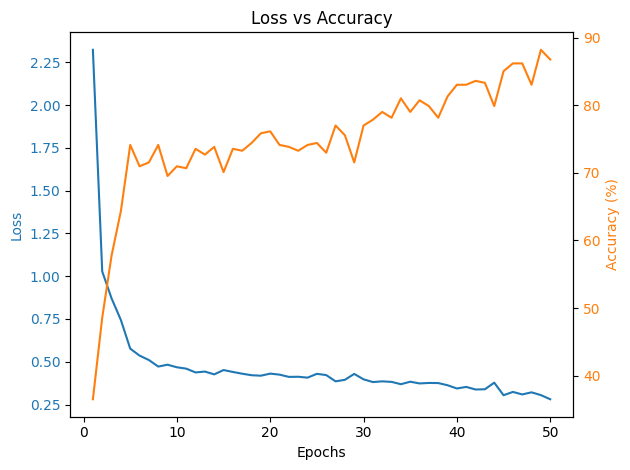

In [28]:
# Plot loss vs accuracy graph
epochs = range(1, num_epochs + 1)

# Create the figure and axis for plotting
fig, ax1 = plt.subplots()

# Plot loss on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, train_losses, color='tab:blue', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:orange')
ax2.plot(epochs, train_accuracies, color='tab:orange', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and show the plot
plt.title('Loss vs Accuracy')
fig.tight_layout()
plt.show()